In [795]:
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import random

In [846]:

def log_score(y, p):
    samples_range = np.arange(len(y))
    return np.mean(np.log(p[samples_range, y]))

In [1037]:
class MultinomialLogReg:
    def __init__(self):
        pass
    
    def softmax(u):
        u = np.hstack((u, np.zeros((u.shape[0], 1))))
        u = u - np.max(u, axis=1, keepdims=True)
        exps = np.exp(u)
        return exps / np.sum(exps, axis=1, keepdims=True)
    
    def build(self, X, y, intercept=True):
        classes_count = int(np.max(y) + 1)
        feats_count = X.shape[1]

        if intercept:
            X = np.hstack((X, np.ones((X.shape[0], 1))))
            feats_count += 1
        
        samples_range = np.arange(X.shape[0])
        def loss(betas):
            betas = betas.reshape((feats_count, classes_count-1))
            probs = MultinomialLogReg.softmax(X @ betas)
            return -np.sum(np.log(probs[samples_range, y]))

        betas_0 = np.zeros((feats_count, classes_count-1))
        betas_opt, _, _ = fmin_l_bfgs_b(loss, betas_0.flatten(), approx_grad=True, maxiter=10000)
        betas_opt = betas_opt.reshape((feats_count, classes_count-1))

        return MultinomialModel(classes_count, feats_count, betas_opt, intercept)


class MultinomialModel:
    def __init__(self, classes_count, feats_count, betas, intercept):
        self.classes_count = classes_count
        self.feats_count = feats_count
        self.betas = betas
        self.intercept = intercept
    
    def predict(self, X, epsilon=0):
        if self.intercept:
            X = np.hstack((X, np.ones((X.shape[0], 1))))

        probs = MultinomialLogReg.softmax(X @ self.betas)
        probs = epsilon + probs
        probs = probs / np.sum(probs, axis=1, keepdims=True)
        return probs

In [1038]:
# generate data by genearting random points inside unit square, classes are based on the quadrants
np.random.seed(0)
X = np.random.rand(1000, 2)*2 - 1
X1 = X + np.random.normal(0, 0.1, (1000, 2))
y = np.zeros(1000, dtype=int)
y[np.logical_and(X1[:, 0] > 0, X1[:, 1] > 0)] = 3
y[np.logical_and(X1[:, 0] > 0, X1[:, 1] < 0)] = 0
y[np.logical_and(X1[:, 0] < 0, X1[:, 1] > 0)] = 1
y[np.logical_and(X1[:, 0] < 0, X1[:, 1] < 0)] = 2

In [1414]:
# generate data by genearting random points inside unit square, classes are based on the quadrants
np.random.seed(0)
X = np.random.rand(1000, 2)*2 - 1
X1 = X + np.random.normal(0, 0.1, (1000, 2))
y = np.zeros(1000, dtype=int)
y[np.logical_and(X1[:, 0] > 0, X1[:, 1] > 0)] = 3
y[np.logical_and(X1[:, 0] > 0, X1[:, 1] < 0)] = 0
y[np.logical_and(X1[:, 0] < 0, X1[:, 1] > 0)] = 1
y[np.logical_and(X1[:, 0] < 0, X1[:, 1] < 0)] = 2


print("My implementation")
model = MultinomialLogReg()
c = model.build(X, y, intercept=False)
prob = c.predict(X)
print("Predictions:")
print(prob.round(4))
print("Betas:")
print(c.betas.round(3))


print()
print("Sklearn implementation")
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='none', fit_intercept=False)
model.fit(X, y)
print("Predictions:")
print(model.predict_proba(X).round(4))
print("Transformed betas:")
print((model.coef_.T - model.coef_.T[:, -1][:, np.newaxis]).round(3))

My implementation
Predictions:
[[7.000e-04 1.576e-01 1.000e-04 8.415e-01]
 [1.708e-01 2.470e-02 5.400e-03 7.991e-01]
 [6.000e-04 9.201e-01 8.100e-03 7.110e-02]
 ...
 [0.000e+00 9.454e-01 1.000e-04 5.450e-02]
 [6.171e-01 2.000e-04 4.000e-04 3.824e-01]
 [4.544e-01 4.200e-03 3.700e-03 5.378e-01]]
Betas:
[[ -0.385 -16.887 -17.135]
 [-16.308  -0.062 -16.394]]

Sklearn implementation
Predictions:
[[7.000e-04 1.576e-01 1.000e-04 8.415e-01]
 [1.708e-01 2.470e-02 5.400e-03 7.991e-01]
 [6.000e-04 9.201e-01 8.100e-03 7.110e-02]
 ...
 [0.000e+00 9.454e-01 1.000e-04 5.450e-02]
 [6.171e-01 2.000e-04 4.000e-04 3.824e-01]
 [4.544e-01 4.200e-03 3.700e-03 5.378e-01]]
Transformed betas:
[[ -0.385 -16.887 -17.135   0.   ]
 [-16.308  -0.062 -16.394   0.   ]]


In [1040]:
prob.round(4)

array([[3.000e-04, 1.564e-01, 1.000e-04, 8.433e-01],
       [9.260e-02, 2.600e-02, 4.500e-03, 8.769e-01],
       [2.000e-04, 9.080e-01, 6.800e-03, 8.510e-02],
       ...,
       [0.000e+00, 9.388e-01, 1.000e-04, 6.110e-02],
       [5.436e-01, 3.000e-04, 4.000e-04, 4.557e-01],
       [3.273e-01, 5.000e-03, 3.400e-03, 6.642e-01]])

In [1041]:
c.betas.round(3)

array([[  0.971, -16.313, -16.813],
       [-16.937,   0.218, -16.227],
       [ -0.927,  -0.187,  -0.365]])

In [1042]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='none', fit_intercept=True)
model.fit(X, y)
model.predict_proba(X).round(4)

array([[3.000e-04, 1.564e-01, 1.000e-04, 8.433e-01],
       [9.260e-02, 2.600e-02, 4.500e-03, 8.769e-01],
       [2.000e-04, 9.080e-01, 6.800e-03, 8.510e-02],
       ...,
       [0.000e+00, 9.388e-01, 1.000e-04, 6.110e-02],
       [5.436e-01, 3.000e-04, 4.000e-04, 4.557e-01],
       [3.273e-01, 5.000e-03, 3.400e-03, 6.642e-01]])

In [1043]:
# get the coefficients

(model.coef_.T - model.coef_.T[:, -1][:, np.newaxis]).round(3)

array([[  0.971, -16.312, -16.812,   0.   ],
       [-16.937,   0.219, -16.226,   0.   ]])

In [1172]:
MBOG_TRAIN = 200
def multinomial_bad_ordinal_good(n, rand):
	# 2d gaussian data directly from rand
    X = np.zeros((n, 2))
    s = np.zeros(n)
    y = np.zeros(n, dtype=int)
    for i in range(n):
        X[i, 0] = rand.gauss(0,3)
        X[i, 1] = rand.gauss(0,1.5)
        s[i] = X[i, 0] + 0.3*X[i, 1] + rand.gauss(0, 0.05)
        
    for j in range(-5, 5):
        select = (s > j) & (s <= j+1)
        y[select] = j+6
    
    y[s>j+1] = j+7
    return X, y

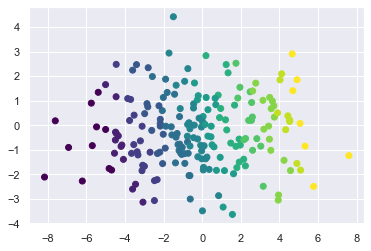

In [1655]:
X, y = multinomial_bad_ordinal_good(MBOG_TRAIN, random.Random(1013))
X1, y1 = multinomial_bad_ordinal_good(1000, random.Random(1014))

# plot
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')

In [1656]:
y

array([ 9,  1,  5,  5,  5,  7,  5,  5,  7,  8,  5,  1,  7,  2,  3,  9,  5,
       11,  3,  7,  8, 10,  5,  4,  1,  9,  2,  5,  5,  2,  5,  4,  6,  6,
        1,  4,  9,  1,  7,  1,  3,  6,  8,  5,  9,  5, 11,  7,  5,  4,  9,
        4, 10,  5,  6,  1,  5,  3,  2,  8,  1,  3,  7,  7,  6,  6,  2,  8,
        6,  6,  8,  6,  6,  3,  2,  0,  7,  1,  4,  3,  4,  4,  9,  0,  0,
        9,  4,  7,  8,  5,  9,  2, 11,  1,  5,  6,  7,  2,  4,  2,  0,  0,
        6,  3,  2,  2,  0,  3,  4,  2,  5,  7,  4,  9,  5,  2,  6,  5, 10,
        8,  4,  5,  3,  9,  6,  3,  0,  5, 11,  4,  2,  2, 10,  4,  7,  4,
        5, 10,  9,  5,  5,  2,  1,  6,  3,  4, 11,  9,  5,  4,  8,  4,  5,
        3,  4,  6, 11,  8,  3,  5,  8,  5,  0,  4,  6,  4,  9,  4,  0,  6,
        8,  8,  4, 10, 11,  8,  2,  7,  5,  6,  7,  9,  5,  9,  1,  7, 10,
        3,  3,  7, 10,  6,  4, 10,  0,  1,  0,  4,  2,  5])

In [1198]:
prob.shape

(1000, 12)

In [1284]:
model = MultinomialLogReg()
c = model.build(X, y, intercept=True)
prob = c.predict(X1, epsilon=1e-10)
log_score(y1, prob)

-1.2995108354337597

In [1200]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='none', fit_intercept=True)
model.fit(X, y)
model.predict_proba(X).round(4)

epsilon = 1e-8
probs = model.predict_proba(X1)
probs = probs + epsilon
probs = probs / np.sum(probs, axis=1, keepdims=True)
log_score(y1, probs)

c:\Users\timkm\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


-0.8508471432196748

---

In [1281]:
class OrdinalLogReg:
    def __init__(self):
        pass
    
    def cdf(x):
        return 1 / (1 + np.exp(-x))
    
    def build(self, X, y, intercept=True, min_delta=1e-8):
        classes_count = int(np.max(y) + 1)
        feats_count = X.shape[1]

        if intercept:
            X = np.hstack((X, np.ones((X.shape[0], 1))))
            feats_count += 1
        
        samples_range = np.arange(X.shape[0])
        def loss(theta):
            betas = theta[:feats_count]
            deltas = np.hstack((0, theta[feats_count:]))
            u = X @ betas

            breaks = np.cumsum(deltas)
            left_breaks = np.hstack((-np.inf, breaks))
            right_breaks = np.hstack((breaks, np.inf))

            u = u[:, np.newaxis]
            probs = OrdinalLogReg.cdf(right_breaks - u) - OrdinalLogReg.cdf(left_breaks - u)

            return -np.sum(np.log(probs[samples_range, y]))
        
        theta_0 = np.zeros((feats_count + classes_count - 2))
        theta_0[feats_count:] = min_delta

        bounds = [(None, None)] * feats_count + [(min_delta, None)] * (classes_count - 2)
        theta_opt, _, _ = fmin_l_bfgs_b(loss, theta_0, bounds=bounds, approx_grad=True, maxiter=10000)
        
        betas = theta_opt[:feats_count]
        deltas = np.hstack((0, theta_opt[feats_count:]))

        return OrdinalModel(classes_count, feats_count, betas, deltas, intercept)


class OrdinalModel:
    def __init__(self, classes_count, feats_count, betas, deltas, intercept):
        self.classes_count = classes_count
        self.feats_count = feats_count
        self.betas = betas
        self.deltas = deltas
        self.intercept = intercept
    
    def predict(self, X, epsilon=0):
        if self.intercept:
            X = np.hstack((X, np.ones((X.shape[0], 1))))

        u = X @ self.betas
        breaks = np.cumsum(self.deltas)
        left_breaks = np.hstack((-np.inf, breaks))
        right_breaks = np.hstack((breaks, np.inf))
    
        u = u[:, np.newaxis]
        probs = OrdinalLogReg.cdf(right_breaks - u) - OrdinalLogReg.cdf(left_breaks - u)
        
        probs = epsilon + probs
        probs = probs / np.sum(probs, axis=1, keepdims=True)
        return probs

In [1282]:
model = OrdinalLogReg()
c = model.build(X, y, intercept=True)

C:\Users\timkm\AppData\Local\Temp\ipykernel_38292\493337510.py:6: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


In [1283]:
prob = c.predict(X1, epsilon=1e-8)
log_score(y1, prob)

C:\Users\timkm\AppData\Local\Temp\ipykernel_38292\493337510.py:6: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


-0.4142214801476432

In [1254]:
# test the loss difference between ordinal and multinomial 100 times
X, y = multinomial_bad_ordinal_good(MBOG_TRAIN, random.Random(1013))
X1, y1 = multinomial_bad_ordinal_good(1000, random.Random(1014))

diffs = []
for i in range(100):
    X, y = multinomial_bad_ordinal_good(MBOG_TRAIN, random.Random(1011+2*i))
    X1, y1 = multinomial_bad_ordinal_good(1000, random.Random(1011+2*i+1))

    model = MultinomialLogReg()
    c = model.build(X, y, intercept=True)
    prob = c.predict(X1, epsilon=1e-8)
    score_m = log_score(y1, prob)

    model = OrdinalLogReg()
    c = model.build(X, y, intercept=True)
    prob = c.predict(X1, epsilon=1e-8)
    score_o = log_score(y1, prob)

    diffs.append(score_o - score_m)


# plot the differences
import seaborn as sns
sns.set()
plt.figure(figsize=(8, 6))
sns.histplot(diffs, kde=True, bins=10)
plt.xlabel("Difference in log-likelihood")
plt.ylabel("Count")
# plt.show()
plt.savefig('differences.svg')

print("Mean difference:", np.mean(diffs).round(2))
print("Stdev of differences:", np.std(diffs).round(2))
print("Percentage of positive differences:", 100* np.mean(np.array(diffs) > 0))


  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:03<06:25,  3.90s/it]C:\Users\timkm\AppData\Local\Temp\ipykernel_38292\493337510.py:6: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
 47%|████▋     | 47/100 [02:01<02:06,  2.38s/it]C:\Users\timkm\AppData\Local\Temp\ipykernel_38292\493337510.py:29: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.log(probs[samples_range, y]))
c:\Users\timkm\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
100%|██████████| 100/100 [04:29<00:00,  2.70s/it]


Mean difference: 0.72
Stdev of differences: 0.5
Percentage of positive differences: 97.0


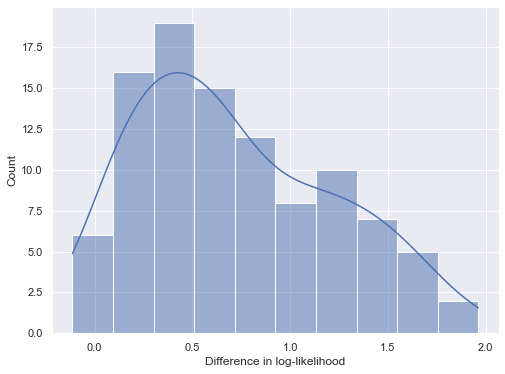

In [1409]:
# plot the differences
import seaborn as sns
sns.set()
plt.figure(figsize=(8, 6))
sns.histplot(diffs, kde=True, bins=10)
plt.xlabel("Difference in log-likelihood")
plt.ylabel("Count")
# plt.show()
plt.savefig('differences.svg')

print("Mean difference:", np.mean(diffs).round(2))
print("Stdev of differences:", np.std(diffs).round(2))
print("Percentage of positive differences:", 100* np.mean(np.array(diffs) > 0))


---

In [1662]:
import pandas as pd

data = pd.read_csv("dataset.csv", sep=";")


y = data["ShotType"]
X = data.drop("ShotType", axis=1)

X = pd.get_dummies(X, columns=["Competition", "PlayerType", "Transition", "TwoLegged", "Movement"])

In [1663]:
# y is ordinal, so we need to convert it to integers
categories = y.unique()
categories = np.hstack((categories[categories != "other"], categories[categories == "other"]))

y = y.map({categories[i]: i for i in range(len(categories))})

categories

array(['above head', 'layup', 'hook shot', 'dunk', 'tip-in', 'other'],
      dtype=object)

In [1455]:

# # function to split the data into train and test
# def split_data(X, y, train_size=0.8):
#     n = len(y)
#     train_n = int(n * train_size)
#     indices = np.arange(n)
#     np.random.shuffle(indices)

#     train_indices = indices[:train_n]
#     test_indices = indices[train_n:]
#     return X.iloc[train_indices], y.iloc[train_indices], X.iloc[test_indices], y.iloc[test_indices]


from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# X_scaled = pd.DataFrame(X_scaled, columns=X.columns)


# function to bootstrap the data
def bootstrap_data(X, y):
    n = len(y)
    indices = np.random.choice(np.arange(n), n, replace=True)
    # oob
    X1, y1 = X.iloc[indices], y.iloc[indices]
    X2, y2 = X.iloc[~np.isin(np.arange(n), indices)], y.iloc[~np.isin(np.arange(n), indices)]
    # standardize
    scaler = StandardScaler()
    scaler = scaler.fit(X1)
    X1 = scaler.transform(X1)
    X2 = scaler.transform(X2)
    return X1, y1, X2, y2

    

In [1498]:
accuracies = []
scores = []
betas = []

np.random.seed(1011)
for i in tqdm(range(100)):
    X1, y1, X2, y2 = bootstrap_data(X, y)
    model = MultinomialLogReg()
    c = model.build(X1, y1, intercept=False)
    prob = c.predict(X2, epsilon=1e-8)
    score = log_score(y2, prob)
    scores.append(score)
    accuracies.append(np.mean(np.argmax(prob, axis=1) == y2))
    betas.append(c.betas)

100%|██████████| 100/100 [31:25<00:00, 18.86s/it]


In [1657]:
print("Mean accuracy:", np.mean(accuracies).round(2), "+-", (np.std(accuracies)).round(2))
print("Mean log-score:", np.mean(scores).round(2), "+-", (np.std(scores)).round(2))

Mean accuracy: 0.73 +- 0.01
Mean log-likelihood: -0.74 +- 0.02


In [1500]:
# # save the results
# import pickle
# with open("multinomial_results.pkl", "wb") as f:
#     pickle.dump({"accuracies": accuracies, "scores": scores, "betas": betas}, f)


In [1572]:
betas2 = []
for b in betas:
    b2 = np.hstack((b, np.zeros((b.shape[0], 1))))
    b2 = b2 - b2.mean(axis=1, keepdims=True)
    betas2.append(b2)

In [1661]:
betas2 = np.array(betas2)
B2 = betas2.mean(axis=0)
B2.round(1)

array([[  0. ,   0.3,  -0.3,  -0. ,  -0.1,   0.1],
       [  1.4,  -2.1,  -0.6,  -0.3,  -0.1,   1.7],
       [ -0. ,  -0.2,   0.2,   0.1,   0.1,  -0.2],
       [ -0. ,  -0. ,  -0.1,   0.2,  -0.1,   0. ],
       [  0. ,   0. ,   0.2,   0. ,   0.1,  -0.4],
       [  0.1,   0.1,  -0.3,  -0.3,  -0.2,   0.5],
       [ -0. ,   0.1,  -0.1,  -0.1,  -0.1,   0.2],
       [ -0. ,  -0. ,   0.1,   0.2,   0. ,  -0.4],
       [  0. ,  -0. ,   0.1,  -0.1,  -0. ,   0.1],
       [ -0. ,   0. ,  -0.1,  -0.1,  -0. ,   0.2],
       [  0. ,  -0. ,   0.1,  -0.1,  -0. ,   0. ],
       [ -0. ,   0. ,  -0.1,   0.1,   0. ,  -0. ],
       [  0.2,  -0.8,   0.2,  -0.3,  -0.2,   0.9],
       [ -0.2,   0.8,  -0.2,   0.3,   0.2,  -0.9],
       [  3. ,   0.3,  -1.6,  -0.6,  -0.6,  -0.6],
       [-13.5,   3.2,   2.1,   2.7,   2.7,   2.8],
       [  3.7,  -1.8,   0.4,  -0.8,  -0.7,  -0.8]])

In [1592]:
# for each feature calculate how many standard deviations it is from 0
stds = betas2.std(axis=0)
np.abs(B2 / stds) > 2

array([[False,  True,  True, False, False, False],
       [ True,  True,  True,  True, False,  True],
       [False,  True,  True, False,  True,  True],
       [False, False,  True,  True, False, False],
       [False, False,  True, False,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [False,  True,  True,  True, False,  True],
       [False, False,  True,  True, False,  True],
       [False, False, False,  True, False, False],
       [False, False,  True, False, False,  True],
       [ True,  True,  True,  True, False, False],
       [ True,  True,  True,  True, False, False],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True]])

In [1659]:
alpha = 0.05
lower = np.percentile(betas2, 100*alpha/2, axis=0)
upper = np.percentile(betas2, 100*(1-alpha/2), axis=0)

B1 = np.empty_like(B2, dtype=object)

# join both
for i in range(B2.shape[0]):
    print()
    for j in range(B2.shape[1]):
        B1[i, j] = f"{B2[i, j].round(1)} ({lower[i, j].round(2)} | {upper[i, j].round(2)})"
        print(B1[i, j], end="\t")



0.0 (-0.05 | 0.05)	0.3 (0.24 | 0.39)	-0.3 (-0.36 | -0.13)	-0.0 (-0.11 | 0.08)	-0.1 (-0.22 | 0.01)	0.1 (-0.09 | 0.19)	
1.4 (1.3 | 1.51)	-2.1 (-2.26 | -1.93)	-0.6 (-0.69 | -0.43)	-0.3 (-0.44 | -0.14)	-0.1 (-0.32 | 0.01)	1.7 (1.29 | 2.11)	
-0.0 (-0.08 | 0.01)	-0.2 (-0.28 | -0.14)	0.2 (0.12 | 0.27)	0.1 (-0.02 | 0.15)	0.1 (0.06 | 0.21)	-0.2 (-0.28 | -0.01)	
-0.0 (-0.06 | 0.03)	-0.0 (-0.1 | 0.04)	-0.1 (-0.2 | -0.02)	0.2 (0.11 | 0.26)	-0.1 (-0.15 | 0.01)	0.0 (-0.1 | 0.14)	
0.0 (-0.05 | 0.08)	0.0 (-0.02 | 0.1)	0.2 (0.15 | 0.31)	0.0 (-0.05 | 0.13)	0.1 (0.05 | 0.21)	-0.4 (-0.68 | -0.28)	
0.1 (0.0 | 0.12)	0.1 (0.09 | 0.18)	-0.3 (-0.4 | -0.17)	-0.3 (-0.32 | -0.21)	-0.2 (-0.24 | -0.12)	0.5 (0.41 | 0.64)	
-0.0 (-0.07 | 0.04)	0.1 (0.07 | 0.22)	-0.1 (-0.27 | -0.05)	-0.1 (-0.22 | -0.04)	-0.1 (-0.18 | 0.01)	0.2 (0.13 | 0.35)	
-0.0 (-0.06 | 0.07)	-0.0 (-0.1 | 0.04)	0.1 (0.06 | 0.23)	0.2 (0.13 | 0.31)	0.0 (-0.05 | 0.13)	-0.4 (-0.67 | -0.13)	
0.0 (-0.02 | 0.08)	-0.0 (-0.08 | 0.02)	0.1 (-0.01 | 0.13)	-0.1 

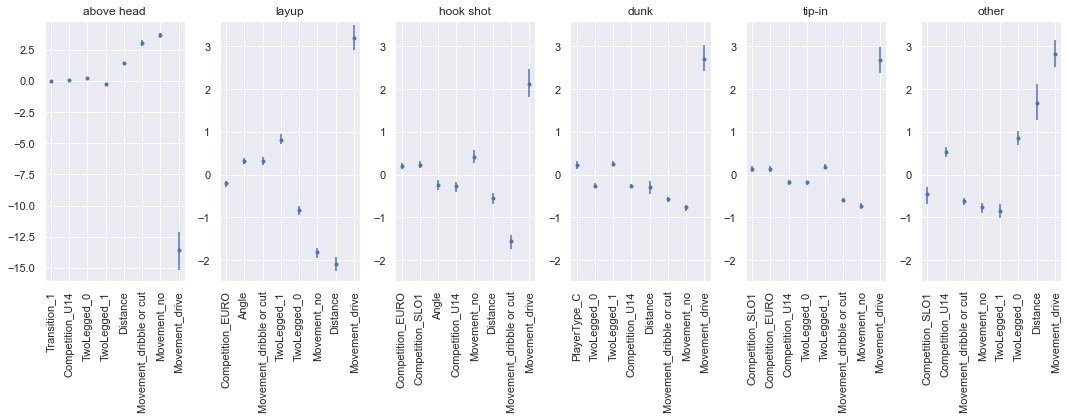

In [1672]:
# for each category (column) get the rows with 5 highest absolute values
# for j in range(B2.shape[1]):
#     print()
#     print("\t", categories[j])
#     for i in np.argsort(np.abs(B2[:, j]))[-5:]:
#         print(B1[i, j], "\t", X.columns[i])

# display the same in a plot as subplots
fig, ax = plt.subplots(1, B2.shape[1], figsize=(15, 6))

for j in range(B2.shape[1]):
    # plt.figure(figsize=(3, 5))
    plt.sca(ax[j])
    most_prominent = np.argsort(np.abs(B2[:, j]))[-8:]
    # display the most prominent features, horizontal plot
    plt.errorbar(np.arange(len(most_prominent)), B2[most_prominent, j], yerr=[B2[most_prominent, j] - lower[most_prominent, j], upper[most_prominent, j] - B2[most_prominent, j]], fmt='.')
    plt.xticks(np.arange(len(most_prominent)), [X.columns[i] for i in most_prominent], rotation=90)
    if j > 0:
        plt.ylim(-2.5, 3.6)
    

    # plt.errorbar(np.arange(B2.shape[0]), B2[:, j], yerr=[B2[:, j] - lower[:, j], upper[:, j] - B2[:, j]], fmt='o')
    # plt.xticks(np.arange(B2.shape[0]), X.columns, rotation=90)
    plt.title(categories[j])
# plt.show()
plt.tight_layout()
plt.savefig('most_important.svg')

In [1670]:
np.random.seed(1101)
x1, y1, x2, y2 = bootstrap_data(X, y)

In [1540]:
model = MultinomialLogReg()
c = model.build(x1, y1, intercept=False)

In [1565]:
c.betas = B
preds = c.predict(x2)

In [1566]:
# calculate accuracy
np.mean(np.argmax(preds, axis=1) == y2)

0.7282191780821918

In [1555]:
log_score(y2.to_numpy(), preds)

-0.7349287325826548

In [1456]:
# compare to sklearn
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='none', fit_intercept=False, max_iter=1000)
model.fit(x1, y1)
preds = model.predict_proba(x2)
print(np.mean(np.argmax(preds, axis=1) == y2))
print(log_score(y2, preds))

0.7254794520547945
-0.7467317511664997


In [1593]:
# join the betas with the feature names
betas_df = pd.DataFrame(B2.T, columns=X.columns)

# add the categories
# betas_df["category"] = categories

In [1594]:
betas_df.round(2)

,Angle,Distance,Competition_EURO,Competition_NBA,Competition_SLO1,Competition_U14,Competition_U16,PlayerType_C,PlayerType_F,PlayerType_G,Transition_0,Transition_1,TwoLegged_0,TwoLegged_1,Movement_dribble or cut,Movement_drive,Movement_no
0,0.00,1.40,-0.04,-0.02,0.01,0.06,-0.02,-0.01,0.02,-0.02,0.04,-0.04,0.22,-0.22,3.03,-13.55,3.66
1,0.31,-2.09,-0.20,-0.03,0.04,0.13,0.14,-0.03,-0.03,0.05,-0.04,0.04,-0.82,0.82,0.32,3.20,-1.82
2,-0.25,-0.55,0.19,-0.10,0.22,-0.27,-0.14,0.13,0.05,-0.15,0.11,-0.11,0.18,-0.18,-1.56,2.12,0.42
3,-0.02,-0.29,0.08,0.19,0.04,-0.26,-0.13,0.22,-0.10,-0.06,-0.08,0.08,-0.26,0.26,-0.57,2.71,-0.77
4,-0.10,-0.13,0.13,-0.07,0.13,-0.17,-0.09,0.04,-0.01,-0.02,-0.05,0.05,-0.18,0.18,-0.60,2.69,-0.73
5,0.05,1.67,-0.16,0.03,-0.45,0.52,0.23,-0.35,0.06,0.20,0.02,-0.02,0.86,-0.86,-0.63,2.83,-0.77


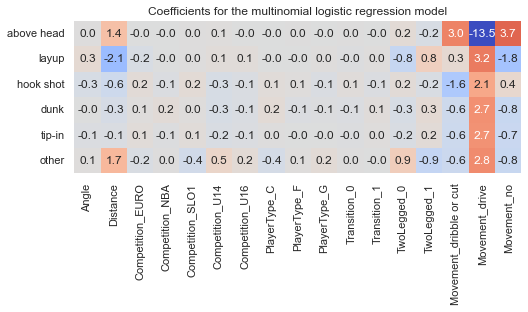

In [1653]:
# visualize the dataframe

import seaborn as sns
sns.set()
plt.figure(figsize=(7.5, 4.5))
# cmap such that positive are blue and negative red
sns.heatmap(betas_df, annot=True, cbar=False, fmt=".1f", cmap="coolwarm", center=0, vmin=-5, vmax=5)
plt.xticks(rotation=90)
plt.yticks(ticks=np.arange(len(categories))+0.5, labels=categories, rotation=0)
plt.title("Coefficients for the multinomial logistic regression model")
plt.tight_layout()
plt.savefig("coefficients.pdf")

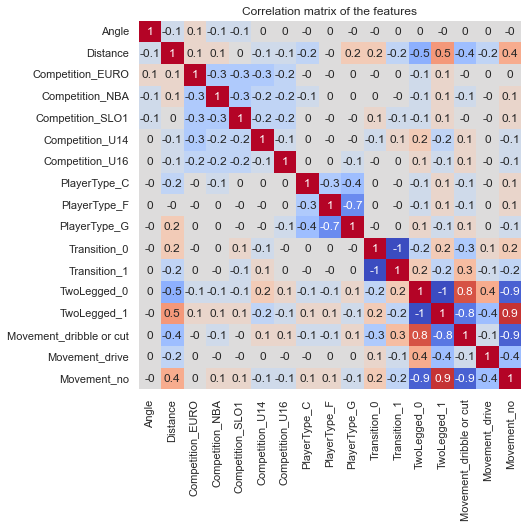

In [1654]:
# plot correlations between features
plt.figure(figsize=(7.5, 7.5))

sns.heatmap(X.corr().round(1), annot=True, cmap='coolwarm', cbar=False)
plt.title("Correlation matrix of the features")
plt.tight_layout()
plt.savefig("correlations.pdf")

array([[ 1.09280522, -1.13936825, -0.61262384, ..., -0.41890291,
        -0.19165418,  0.47598582],
       [-0.66128285, -1.03469019, -0.61262384, ..., -0.41890291,
        -0.19165418,  0.47598582],
       [ 0.25030559,  1.20325452, -0.61262384, ..., -0.41890291,
        -0.19165418,  0.47598582],
       ...,
       [-0.71002884, -1.10327237,  1.63232303, ..., -0.41890291,
        -0.19165418,  0.47598582],
       [-1.60971865,  0.53909028,  1.63232303, ..., -0.41890291,
        -0.19165418,  0.47598582],
       [-1.6592323 , -0.88308749,  1.63232303, ..., -0.41890291,
        -0.19165418,  0.47598582]])

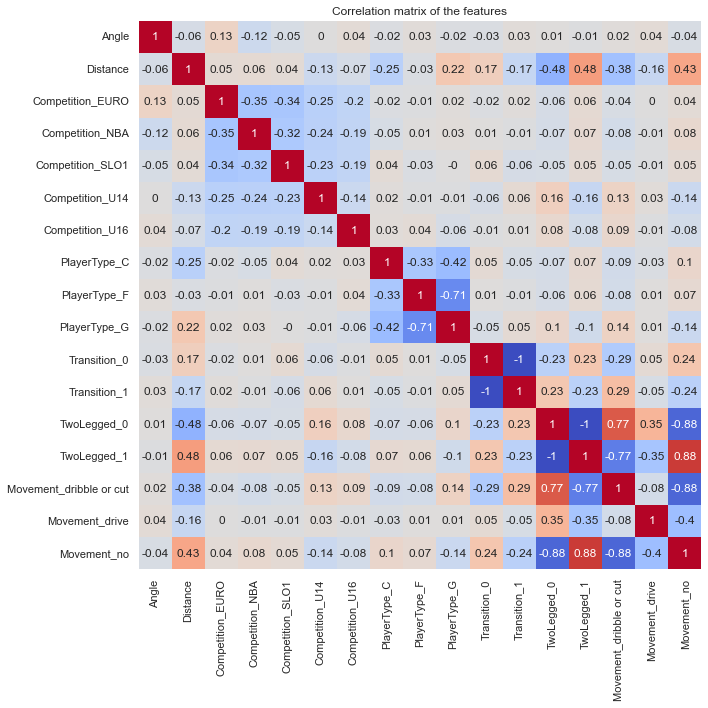

In [1405]:
# standardize X

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled = pd.DataFrame(X_scaled, columns=X.columns)